In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
#imports
from sklearn.metrics import mean_squared_error, make_scorer
import sklearn
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
%cd /content/drive/MyDrive/NBeats

/content/drive/MyDrive/NBeats


In [3]:
#read dataframe
df = pd.read_csv("Dataset_Microbusiness_Density/train.csv")
df = df[['cfips','microbusiness_density','first_day_of_month']]

#change column name 'microbusiness_density' to 'y'
df = df.rename(columns={'microbusiness_density': 'y'})
#change column name 'first_day_of_month' to 'ds'
df = df.rename(columns={'first_day_of_month': 'ds'})

#convert date to timestemp
df['ds'] = pd.to_datetime(df['ds'])

#set indices and sort by 'ds'
df = df.set_index(['ds','cfips'])
df = df.sort_index(level=['ds'],ascending=True)

#unstack dataframe and drop extra level
df = df.unstack(level=-1)
df.columns = df.columns.droplevel(0)


#collect column names
c=[]
for col in df.columns:
  c.append(col)

# Data start date
start_date = '2019-08-01'
# Data end date. yfinance excludes the end date, so we need to add one day to the last day of data
end_date = '2022-10-01' 
# Date for splitting training and testing dataset
train_end_date = '2021-10-01'

#set y, aka select given area
y = 1007

#set X
variables = c
variables.remove(y)

#create dataframe with columns=y, X
v = [str(x) for x in variables]
df = df.reset_index()
liste=['ds','y']
liste = liste+v
df.columns = liste
#v = v[:16]
df = df[['y']+v]

#print(df.head())

/content/drive/MyDrive/NBeats/nbeats_keras
Keras training...
Epoch 1/30
1/1 [==============================] - 5s 5s/step - loss: 0.8812 - val_loss: 0.2090
Epoch 2/30
1/1 [==============================] - 0s 43ms/step - loss: 0.2664 - val_loss: 0.4517
Epoch 3/30
1/1 [==============================] - 0s 45ms/step - loss: 0.3687 - val_loss: 0.4910
Epoch 4/30
1/1 [==============================] - 0s 63ms/step - loss: 0.4273 - val_loss: 0.3105
Epoch 5/30
1/1 [==============================] - 0s 44ms/step - loss: 0.2806 - val_loss: 0.2153
Epoch 6/30
1/1 [==============================] - 0s 58ms/step - loss: 0.1273 - val_loss: 0.2554
Epoch 7/30
1/1 [==============================] - 0s 43ms/step - loss: 0.1664 - val_loss: 0.2490
Epoch 8/30
1/1 [==============================] - 0s 40ms/step - loss: 0.2180 - val_loss: 0.2193
Epoch 9/30
1/1 [==============================] - 0s 44ms/step - loss: 0.1836 - val_loss: 0.1740
Epoch 10/30
1/1 [==============================] - 0s 51ms/step - lo

1/1 [==============================] - 0s 211ms/step


1/1 [==============================] - 0s 236ms/step


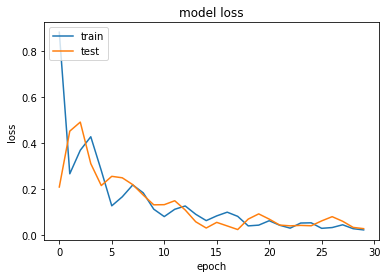

In [5]:
%cd /content/drive/MyDrive/NBeats/nbeats_keras
from model import NBeatsNet as NBeatsKeras
warnings.filterwarnings(action='ignore', message='Setting attributes')


def main():
    num_samples = len(df.index)
    input_dim = 1
    output_steps = 1
    time_steps = len(df.index)

    # Definition of the model
    model_keras = NBeatsKeras(backcast_length=time_steps, forecast_length=output_steps,
                              stack_types=(NBeatsKeras.GENERIC_BLOCK, NBeatsKeras.GENERIC_BLOCK),
                              nb_blocks_per_stack=2, thetas_dim=(4, 4), share_weights_in_stack=True,
                              hidden_layer_units=64)

    # Definition of the objective function and the optimizer.
    model_keras.compile(loss='mae', optimizer='adam')

    # Definition of the data
    x = np.random.uniform(size=(num_samples, time_steps, input_dim))
    y = np.mean(x, axis=1, keepdims=True)

    # Split data into training and testing datasets
    c = num_samples // 10
    x_train, y_train, x_test, y_test = x[c:], y[c:], x[:c], y[:c]
    test_size = len(x_test)

    # Train the model
    print('Keras training...')
    history = model_keras.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30, batch_size=128)
  
    # Save the model for later
    model_keras.save('n_beats_model.h5')

    # Predict on the testing set (forecast)
    predictions_keras_forecast = model_keras.predict(x_test)
    np.testing.assert_equal(predictions_keras_forecast.shape, (test_size, model_keras.forecast_length, output_steps))

    # Predict on the testing set (backcast).
    predictions_keras_backcast = model_keras.predict(x_test, return_backcast=True)
    np.testing.assert_equal(predictions_keras_backcast.shape, (test_size, model_keras.backcast_length, output_steps))

    # Load the model.
    model_keras_2 = NBeatsKeras.load('n_beats_model.h5')

    np.testing.assert_almost_equal(predictions_keras_forecast, model_keras_2.predict(x_test))

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


if __name__ == '__main__':
    main()